In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(monocle3, quietly = T)
    library(SeuratWrappers, quietly = T)
    
    library(ggplot2, quietly = T)
    library(cowplot, quietly = T)
})

In [2]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
}

Associated tutorials:

1) https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/
2) http://htmlpreview.github.io/?https://github.com/satijalab/seurat-wrappers/blob/master/docs/monocle3.html
3) https://stuartlab.org/signac/articles/monocle.html

In [3]:
# Load and format T cell data to get just the CD8s

In [4]:
abc.tcells<-readRDS(paste0(data_path, 'processed/abc_tcells.RDS'))
Idents(abc.tcells)<-'Cell.Type.Level2'

Subset to just the CD8+ T cells

In [5]:
abc.cd8s.all<-abc.tcells[, unname(sapply(as.character(abc.tcells$Cell.Type.Level2), function(x) startsWith(x, 'CD8+')))]

We want to place the root node at the CD8 naive T-cells Looking at the UMAP, we can see there is a main group of CD8+ naive T-cells (clusters 30, 41, and 43) and then an additional cluster (cluster 44) that is transcriptionally distinct in UMAP space. Accordingly, we would like to set the root node based on the main cluster:

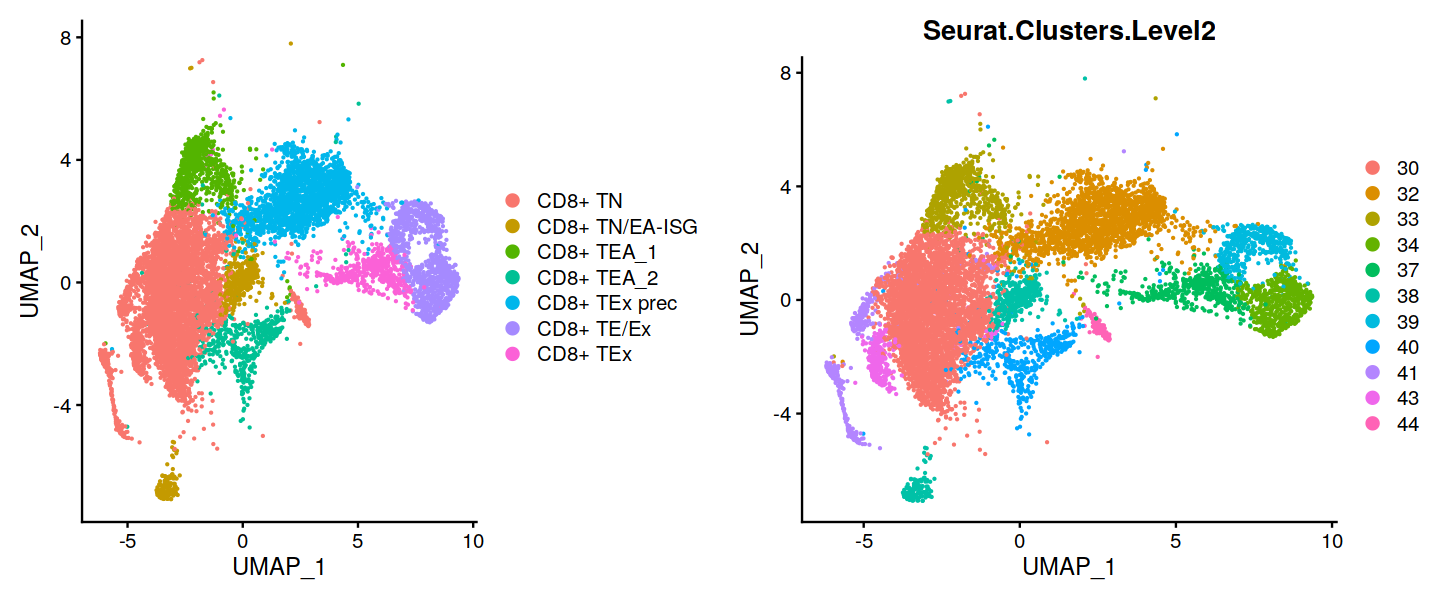

In [6]:
h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-DimPlot(abc.cd8s.all)
g1B<-DimPlot(abc.cd8s.all, group.by = 'Seurat.Clusters.Level2')
g1<-cowplot::plot_grid(g1A, g1B, ncol = 2)
g1

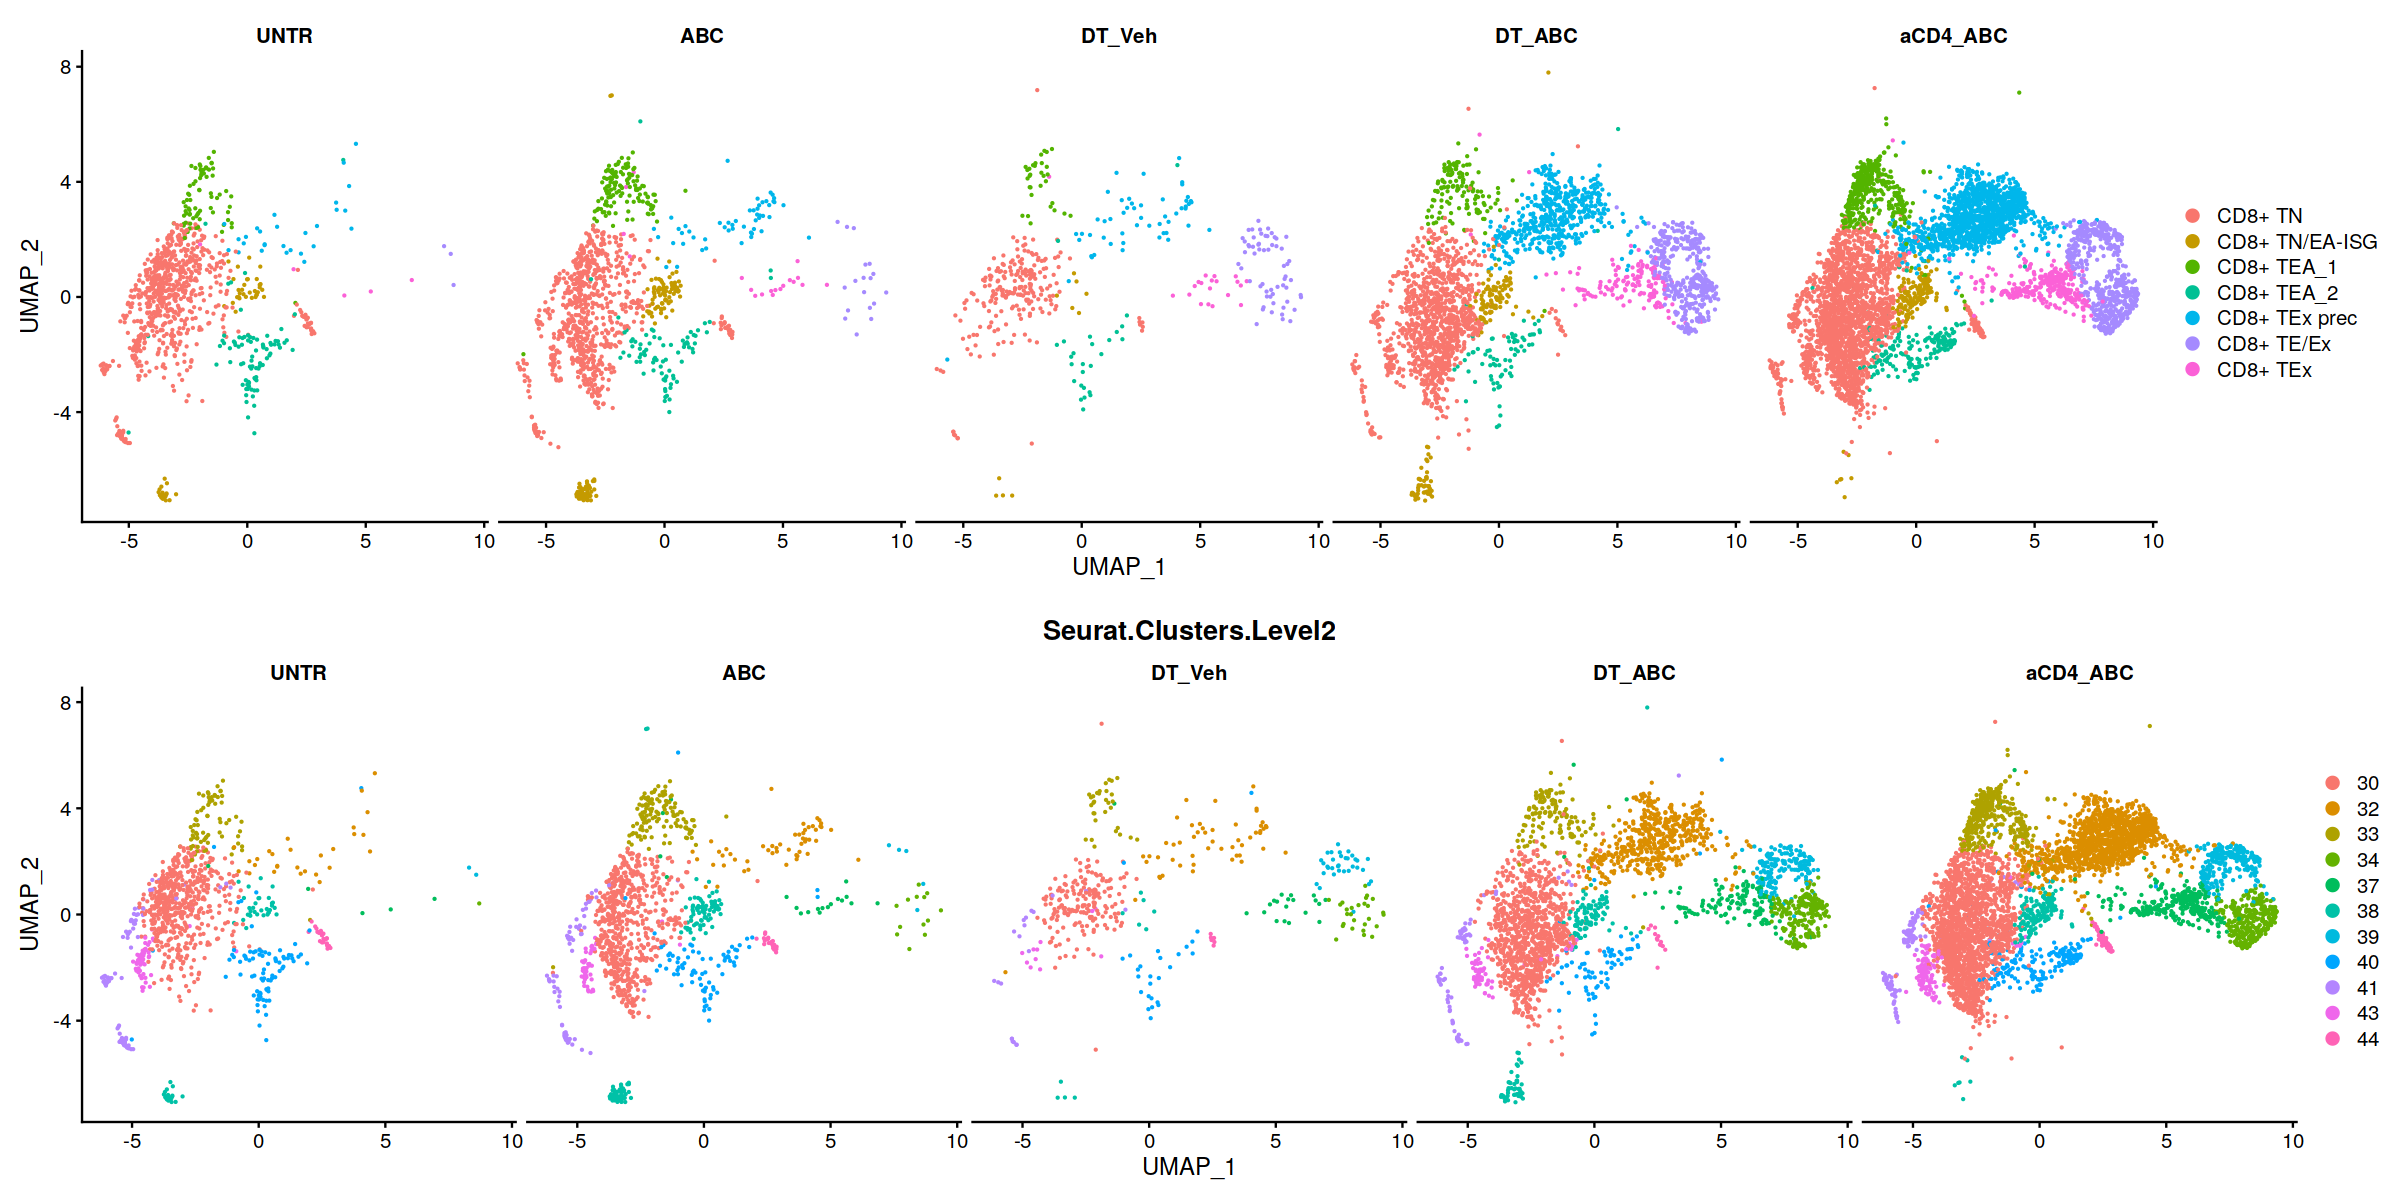

In [7]:
h_ = 10
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g2A<-DimPlot(abc.cd8s.all, split.by = 'orig.ident')
g2B<-DimPlot(abc.cd8s.all, group.by = 'Seurat.Clusters.Level2', split.by = 'orig.ident')
g2<-cowplot::plot_grid(g2A, g2B, ncol = 1)
g2

In [8]:
md<-abc.cd8s.all@meta.data

md[['Root.Node']]<-'no'
md[(md$Cell.Type.Level2 == 'CD8+ TN') & (md$Seurat.Clusters.Level2 != '44'), 'Root.Node']<-'yes'
abc.cd8s.all@meta.data<-md

Split into each context:

In [9]:
abc.cd8s.so<-Seurat::SplitObject(abc.cd8s.all, split.by = 'orig.ident')

Do the trajectory analysis:

In [10]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, root.node="yes"){
  cell_ids <- which(colData(cds)[, "Root.Node"] == root.node)
  
  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

calculate trajectory on each condition separately

<span style="color:red">**Note, this does not set the same root across conditions**, but for each condition, it does the following as specified by the Monocle [tutorial](https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/):

>It's often desirable to specify the root of the trajectory programmatically, rather than manually picking it. The function below does so by first grouping the cells according to which trajectory graph node they are nearest to. Then, it calculates what fraction of the cells at each node come from the earliest time point. Then it picks the node that is most heavily occupied by early cells and returns that as the root.

<span style="color:red">Techically, it would not be possible to set the same root since the trajectory is calculated separately on each context, but an alternative option we could try is to find the node  in each context that is closest to the one that would be set if we did it for all contexts together.

In [11]:
abc.cd8s <- lapply(X = abc.cd8s.so, FUN = function(x){
    x<-SeuratWrappers::as.cell_data_set(x)
    x<-monocle3::cluster_cells(cds = x)
    x<-monocle3::learn_graph(cds = x)#, use_partition = F) 

#     cd8_tn<-rownames(colData(x)[x$Cell.Type.Level2 == 'CD8+ TN', ])
#     x<-monocle3::order_cells(x, root_cells = cd8_tn) # get trajectory with CD8 TN as root
    x <- order_cells(x, root_pr_nodes=get_earliest_principal_node(x))
})

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [17]:
traj.plots<-list()
for (i in seq_along(abc.cd8s)){

    g1<-DimPlot(abc.cd8s.so[[i]]) + ggtitle(paste0('Condition: ', names(abc.cd8s)[[i]]))
    
#     if (i != length(abc.cd8s)){
#         g1<-g1 + theme(legend.position="none")
#     }
    
    g2<-plot_cells(cds = abc.cd8s[[i]], color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
                   trajectory_graph_segment_size = 0.4,
                   graph_label_size = 3,
              label_cell_groups=FALSE, label_roots = TRUE,
               label_leaves=TRUE,
               label_branch_points=TRUE)
    g<-cowplot::plot_grid(g1, g2, ncol = 1)#g1 + g2
    traj.plots[[names(abc.cd8s)[[i]]]]<-g
}

white circles are roots, gray circles are leaves, blue circles are branch points:

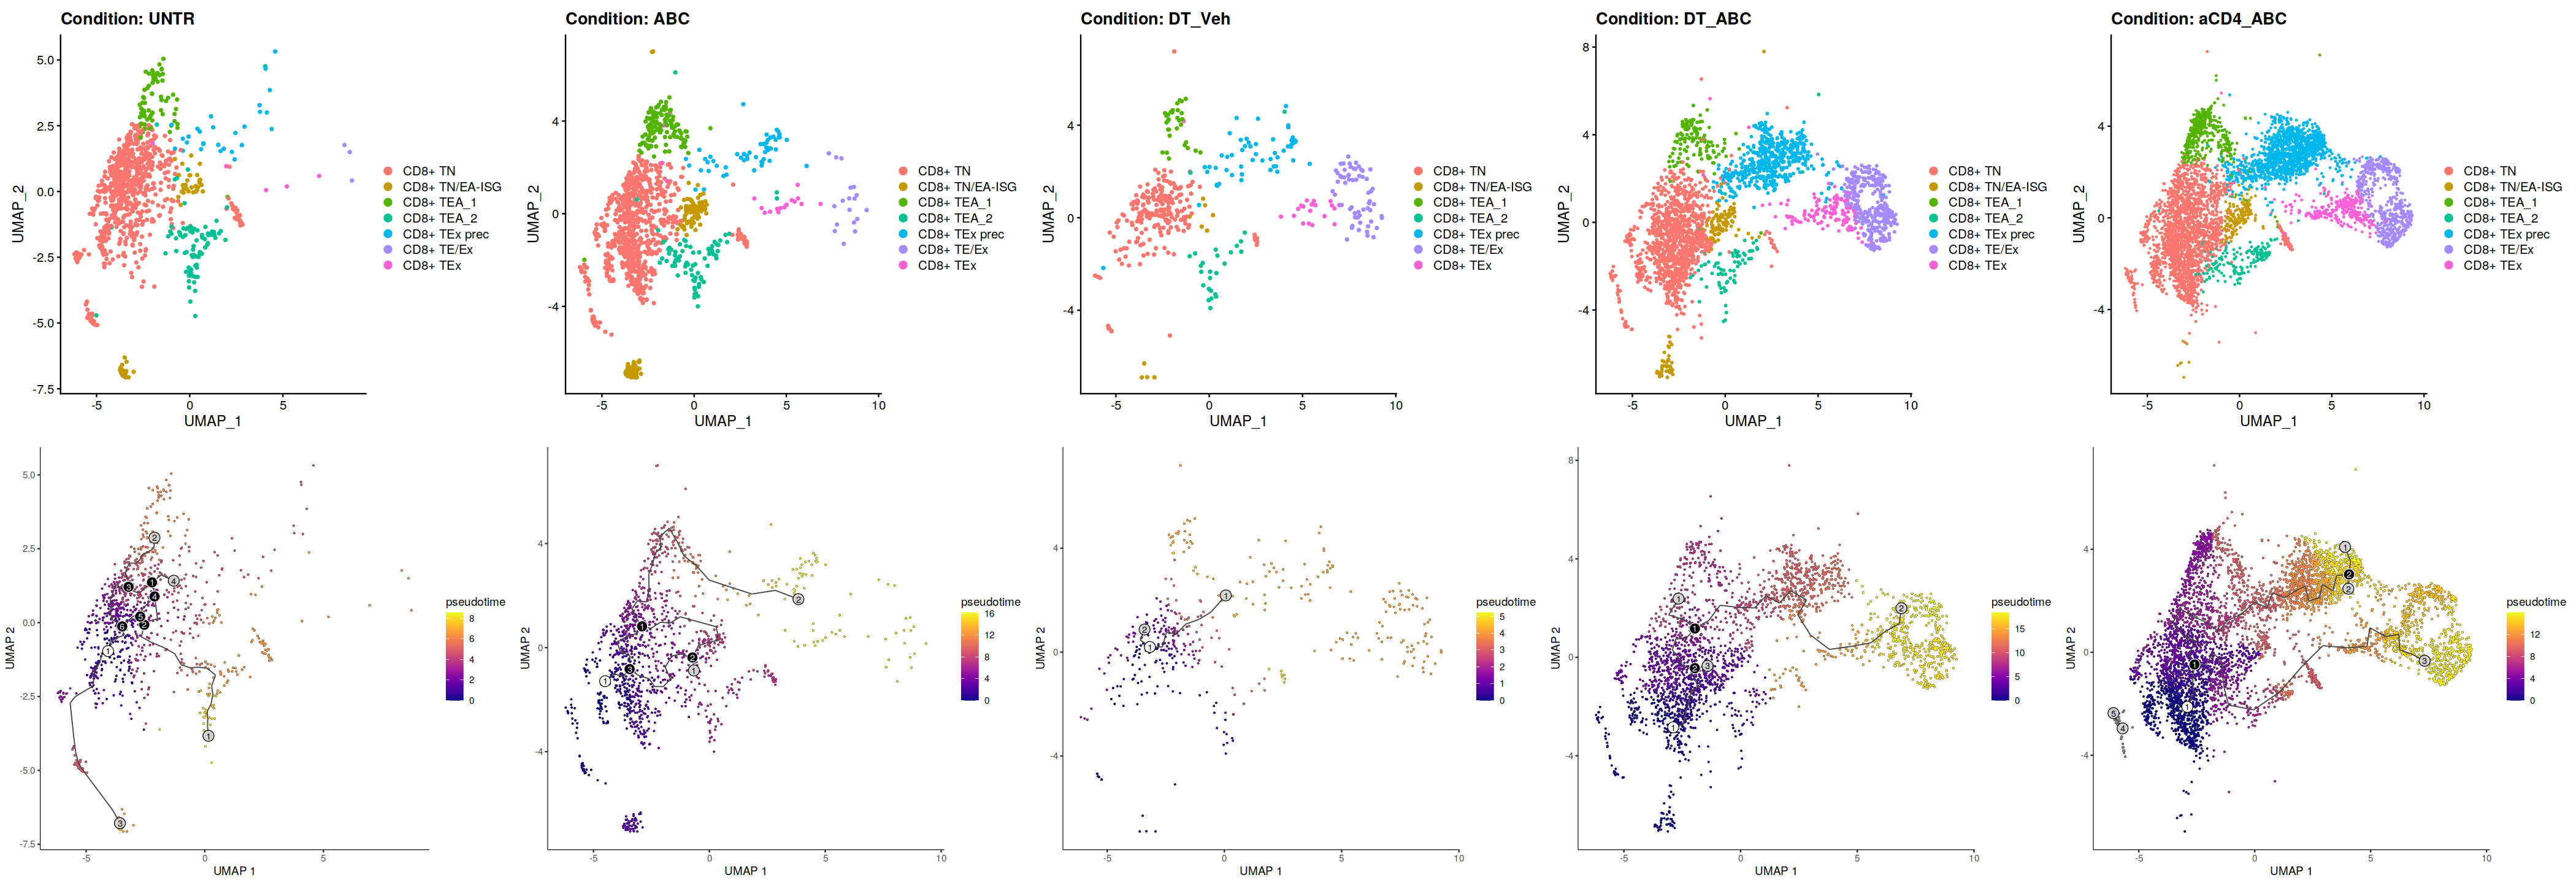

In [18]:
h_ = 12
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

g1<-cowplot::plot_grid(plotlist=traj.plots, ncol = length(traj.plots))

for (ext in c('.svg', '.png', '.pdf')){
    fn<-paste0(data_path, 'figures/', 'cd8_trajectory_separate', ext)
    ggsave(fn, g1, height = h_, width = w_)}

g1